# E-Commerce Price Monitoring — Minimal Variant



**1 . Load CSV & quick preview:**

In [6]:
# Load the provided CSV (make sure it's uploaded to the Colab working directory)
import pandas as pd
import os


csv_name = "clean_books_data.csv"
if not os.path.exists(csv_name):
    raise FileNotFoundError(f"{csv_name} not found in current folder. Upload it to Colab first.")

data = pd.read_csv(csv_name)
print("Columns found:", list(data.columns))
print("\nPreview:")
display(data.head(6))


Columns found: ['Product Name', 'Price (£)', 'Availability']

Preview:


,Product Name,Price (£),Availability
0,A Light in the Attic,51.77,In stock
1,Tipping the Velvet,53.74,In stock
2,Soumission,50.10,In stock
3,Sharp Objects,47.82,In stock
4,Sapiens: A Brief History of Humankind,54.23,In stock
5,The Requiem Red,22.65,In stock


In [7]:
# (Usually pandas & matplotlib are preinstalled on Colab; this is optional)
!pip install -q pandas matplotlib


##4 — Simple cleaning + normalize column names

In [8]:
# Light cleaning: normalize column names and ensure price is numeric
df = data.copy()

# make column names consistent (lowercase, remove extra spaces)
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Try to find a price column (common variants); otherwise raise an informative error
price_col_candidates = ["price_£", "price(£)", "price_£", "price", "price_£", "price_£", "price_ (gbp)", "price_(gbp)", "price_£)"]
price_col = None
for c in df.columns:
    if "price" in c:
        price_col = c
        break

if price_col is None:
    raise ValueError("Could not detect a price column automatically. Columns: " + ", ".join(df.columns))

# Clean price values: remove currency symbols and convert to float
def parse_price(x):
    if pd.isna(x):
        return None
    s = str(x).strip().replace("£", "").replace(",", "")
    try:
        return float(s)
    except:
        return None

df["price_gbp"] = df[price_col].apply(parse_price)

# Keep only useful columns (if they exist)
possible_title_cols = [c for c in df.columns if "title" in c or "name" in c or "product" in c]
title_col = possible_title_cols[0] if possible_title_cols else None
if title_col:
    df = df[[title_col, "price_gbp"] + [c for c in df.columns if c not in (title_col, "price_gbp")]]
else:
    # fallback: keep everything but ensure price_gbp present
    df = df

# Drop rows without price
before = len(df)
df = df.dropna(subset=["price_gbp"]).reset_index(drop=True)
after = len(df)
print(f"Dropped {before-after} rows with missing/invalid prices. Rows remaining: {after}")

display(df.head(5))


Dropped 0 rows with missing/invalid prices. Rows remaining: 100


,product_name,price_gbp,price_(£),availability
0,A Light in the Attic,51.77,51.77,In stock
1,Tipping the Velvet,53.74,53.74,In stock
2,Soumission,50.10,50.10,In stock
3,Sharp Objects,47.82,47.82,In stock
4,Sapiens: A Brief History of Humankind,54.23,54.23,In stock


##5 — Simple analysis: price buckets and table

In [9]:
# Create simple price buckets so visualization looks neat
bins = [0, 10, 20, 30, 40, 50, 100, 1000]   # adjust if prices are higher
labels = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-99", "100+"]
df["price_bucket"] = pd.cut(df["price_gbp"], bins=bins, labels=labels, right=False)

# Aggregation table
summary = df.groupby("price_bucket").agg(
    count = ("price_gbp", "count"),
    median_price = ("price_gbp", "median"),
    mean_price = ("price_gbp", "mean")
).reset_index()

print("Price bucket summary:")
display(summary)


Price bucket summary:


/tmp/ipython-input-258907341.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("price_bucket").agg(


,price_bucket,count,median_price,mean_price
0,0-9,0,NaN,NaN
1,10-19,26,17.020,16.514231
2,20-29,14,23.465,23.422857
3,30-39,20,34.775,34.887500
4,40-49,17,45.170,44.796471
5,50-99,23,53.900,53.890870
6,100+,0,NaN,NaN


##6 — Simple chart (bar plot of buckets)

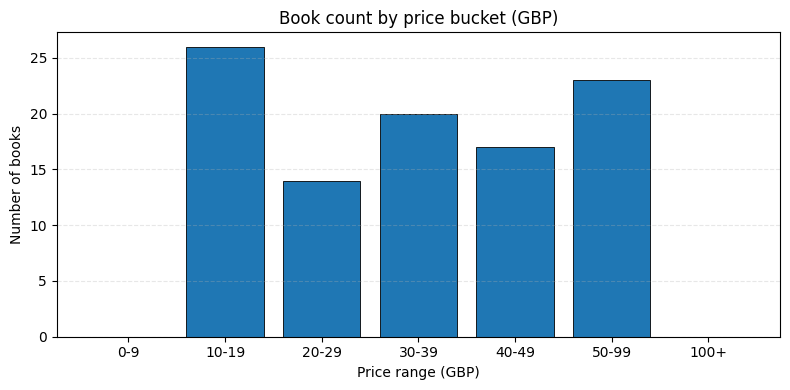

In [10]:
import matplotlib.pyplot as plt

# Bar chart — counts per bucket (keeps style simple and distinct from friend's output)
plt.figure(figsize=(8,4))
counts = summary["count"].fillna(0)
plt.bar(summary["price_bucket"].astype(str), counts, edgecolor="k", linewidth=0.6)
plt.title("Book count by price bucket (GBP)")
plt.xlabel("Price range (GBP)")
plt.ylabel("Number of books")
plt.grid(axis="y", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


##7 — Save cleaned CSV

In [11]:
# Save cleaned version (so the original remains unchanged)
out_file = "my_variant_clean_books.csv"
df.to_csv(out_file, index=False)
print(f"Saved cleaned CSV as: {out_file}")


Saved cleaned CSV as: my_variant_clean_books.csv
